# Step 4: Fit Barnacle model to your data

Use this notebook to fit the Barnacle model to your normalized data tensor. Fitting Barnacle to data requires tuning two model parameters: 
1. `R` -- the number of components
1. `lambda` -- the sparsity parameter

There are many methods for fitting model parameters. The cross-validated parameter search strategy here is the method used to fit Barnacle to metatranscriptomic data in the [original Barnacle manuscript](https://doi.org/10.1101/2024.07.15.603627). This strategy aims to reduce resource costs by fitting `R` first and then `lambda`, rather than both parameters simultaneously. It also depends on sample replicates for performing cross validation. If your data does not have sample replicates, you might instead consider trying split-half analysis for parameter selection, and if you have more compute resources at your disposal, you might consider a full grid search of both `R` and `lambda` parameters simultaneously to find the optimal combination.

Please refer to the notebook [3-tensorize-data.ipynb](https://github.com/blasks/barnacle-boilerplate/blob/main/3-tensorize-data.ipynb) for proper formatting of your input data tensor. Note that in order to facilitate bootstrapping, sample ID and replicate ID are combined into a unique identifier called `'sample_replicate_id'` (how creative). This will be the name of the third mode of your tensor. The sample ID and replicate ID information is preserved in separate metadata arrays in the dataset. The script will use this information to shuffle replicates between bootstraps, which enables more robust parameter selection, and confidence intervals in the final model.

In [90]:
# imports

import os
import pandas as pd
import seaborn as sns
import toml
import warnings
import xarray as xr

from matplotlib import pyplot as plt

# suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# set color palette
sns.set_palette(sns.color_palette([
    '#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', '#959AB1', '#FFDB66', '#FFB1CA', '#63B9FF', '#4F1DD7'
]))


In [88]:
# get user inputs

# data file
datapath = input('Enter the filepath of your input data tensor (e.g. directory/example-tensor.nc):')
# check data file exists
if not os.path.isfile(datapath):
    raise Exception(f'Unable to find the file "{datapath}"')
ds = xr.open_dataset(datapath)

# check input data formats
required_vars = ['data', 'sample_id', 'replicate_id', 'sample_replicate_id']
for var in required_vars:
    if var not in list(ds.variables):
        raise Exception(f"Tensor missing variable '{var}'. See `3-tensorize-data.ipynb` for proper formatting of input tensor dataset.")
if input(f'Found tensor with the following modes and dimensions:\n{dict(ds.sizes)}\nIs this correct? (Y/N):').strip().lower() == 'n':
    raise Exception(f'Please double check input tensor dataset.')
else:
    modes = list(ds.data.coords)
    mode_description = f'1-{modes[0]}, 2-{modes[1]}, 3-{modes[2]}'

# output directory
outdir = input('Enter the path of the output directory where you want files saved:')
# check output directory exists
if not os.path.isdir(outdir):
    raise Exception(f'Unable to find the directory "{outdir}"')

# input constant model parameters
nonneg_modes = [int(x)-1 for x in input(f'Which modes are non-negative? {mode_description}, (Enter 1/2/3, comma-separated)').split(',')]
sparse_modes = int(input(f'How many modes will sparsity be applied to? (Enter 0/1/2/3, default is 1)'))
if sparse_modes == 1:
    if input(f'Sparsity will be applied to mode 1-{modes[0]}\nIs this correct? (Y/N):').strip().lower() == 'n':
        raise Exception('Sparsity constraint should be applied to the first mode in the tensor. Please rearrange input tensor.')
elif sparse_modes == 2:
    if input(f'Sparsity will be applied to modes 1-{modes[0]} and 2-{modes[1]}\nIs this correct? (Y/N):').strip().lower() == 'n':
        raise Exception('Sparsity constraints should be applied to first and second modes in the tensor. Please rearrange input tensor.')

ds

KeyboardInterrupt: Interrupted by user

### Part A: Identifying optimal rank

In this step we will identify the optimal rank of the model. The rank dictates the number of components in the model. If you are interested in clustering your data, this directly corresponds to the number of clusters the model will describe.

We identify the optimal rank (number of components) for your dataset via cross-validation. We will fit a series of models with different rank values, and then compare how well these models reproduce held out replicates from your dataset. To isolate the rank parameter from the sparsity parameter, this first cross validation is done without applying any sparsity to the model.

Identifying the optimal rank requires the following steps:
1. Enter a list of rank values you would like to assess. A good starting range might be 1 - 30 in intervals of 5.
1. Run the `grid-search.py` script using the config file generated by this notebook (`rank-search.toml`).
    - You should run this script from the command line, outside of this notebook.
    - This step can last anywhere from minutes to days, or more, depending on the size of your data, the rank values you are testing, and the specs of your computer system. If it is taking a long time to run, consider testing a smaller set of rank values, running fewer bootstraps, running on a more powerful computer, or distilling your data down to a subset you are most interested in analyzing.
1. Look for a minimum in the cross-validated sum of squared errors (SSE).
    - If you do not see a minimum, you may need to repeat these steps, testing a broader range of rank values.


In [53]:
# USER INPUTS -- edit these variables as needed

# list values of R (rank) to test
ranks = [1, 5, 10, 15, 20, 25, 30]

# enter random seed (integer)
seed = 9481


In [62]:
# build config file

# config file structure
config = {
    "grid": {
        "ranks": ranks,
        "lambdas": [[0., 0., 0.]]
    },
    "params": {
        "nonneg_modes": nonneg_modes,
        "tol": 0.00001, 
        "n_iter_max": 2000,
        "n_initializations": 5
    },
    "script": {
        "input": datapath,
        "outdir": f"{outdir}/fitting",
        "n_bootstraps": 10,
        "replicates": [str(l) for l in set(ds.replicate_id.data)],
        "max_processes": os.cpu_count(),
        "seed": seed
    }
}

# function to save config as toml file
def save_toml(config, filename="config.toml"):
    with open(filename, "w") as f:
        toml.dump(config, f)
    print(f"TOML file '{filename}' created successfully.")

# save and display config toml file
save_toml(config, filename=f"{outdir}/rank-search.toml")
print(f"\n{toml.dumps(config)}")

# print command to initiate rank search
print(
    f"""Run the following command from the command line:

    poetry run python grid-search.py {outdir}/rank-search.toml
    """
)


TOML file 'data/rank-search.toml' created successfully.

[grid]
ranks = [ 1, 5, 10, 15, 20, 25, 30,]
lambdas = [ [ 0.0, 0.0, 0.0,],]

[params]
nonneg_modes = [ 1, 2,]
tol = 1e-5
n_iter_max = 2000
n_initializations = 5

[script]
input = "data/data-tensor.nc"
outdir = "data/fitting"
n_bootstraps = 10
replicates = [ "A", "B", "C",]
max_processes = 16
seed = 9481

Run the following command from the command line:

    poetry run python grid-search.py data/rank-search.toml
    


#### Initialize cross-valiated rank search

Run the above command from your computer's command line. This step may take anywhere from minutes to days to complete. Once it has successfully completed, it should have produced a number of directories and files within your output directory, including the following csv file that contains the cross-validated SSE data:

`fitting/cv_data.csv`

You can then run the following code to look for a minimum in the cross-validated SSE data. 

The minimum average cross-validated SSE was 0.954, acheived with R=5
Please re-run the rank search to include higher values of rank.


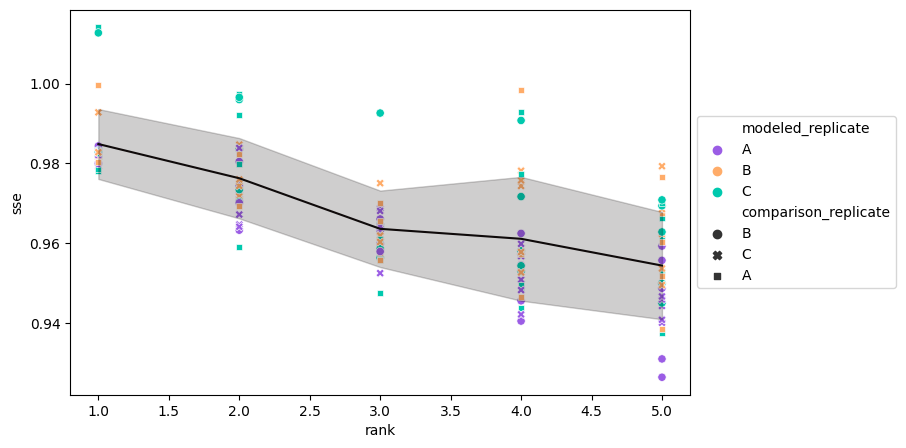

In [102]:
# visualize the result of the cross validation run

# read in cross-validation data
cv_df = pd.read_csv(f"{outdir}/fitting/cv_data.csv")
# down-select to just true cross-validation data
cv_df = cv_df[cv_df['modeled_replicate'] != cv_df['comparison_replicate']].reset_index(drop=True)

# calculate minimum average cross-validated SSE
avg_cv_sse = cv_df.groupby('rank').sse.mean()
rank_min_sse = avg_cv_sse.idxmin()
print(f'The minimum average cross-validated SSE was {avg_cv_sse.min():.3}, acheived with R={rank_min_sse}.')
if rank_min_sse == cv_df['rank'].min():
    if rank_min_sse == 1:
        print('This may indicate a high level of noise in your data. You may need to reconsider preprocessing and normalization.')
    else:
        print('Please re-run the cross-validated rank search to include lower values of rank.')
elif rank_min_sse == cv_df['rank'].max():
    print('Please re-run the cross-validated rank search to include higher values of rank.')
else:
    optimal_rank = rank_min_sse
    print(f'This indicates an optimal rank value of {optimal_rank}. Proceed to select the optimal value of lambda.')

# plot cross-validated SSE as a function of rank
fig, axis = plt.subplots(figsize=(8,5))
sns.scatterplot(data=cv_df, x='rank', y='sse', hue='modeled_replicate', style='comparison_replicate', ax=axis, legend=True)
sns.lineplot(data=cv_df, x='rank', y='sse', color=sns.color_palette()[4], errorbar='sd', ax=axis)
axis.legend(loc='center left', bbox_to_anchor=(1,0.5));
